[*********************100%***********************]  1 of 1 completed

Epoch 1/50



/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 57ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 7.8889e-05 - val_loss: 0.0012
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 67ms/step - loss: 6.1637e-05 - val_loss: 0.0015
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 6.5249e-05 - val_loss: 0.0015
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 6.7937e-05 - val_loss: 0.0032
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 65ms/step - loss: 4.9014e-05 - val_loss: 0.0017
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.6081e-05 - val_loss: 0.0022
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.2428e-05 - val_loss: 0.0025
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 60ms/step - loss: 4.4102e-05 - val_loss: 0.0077
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.1073e-05 - val_loss: 0.0035
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 5.0751e-05 - val_loss: 0.0057
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━

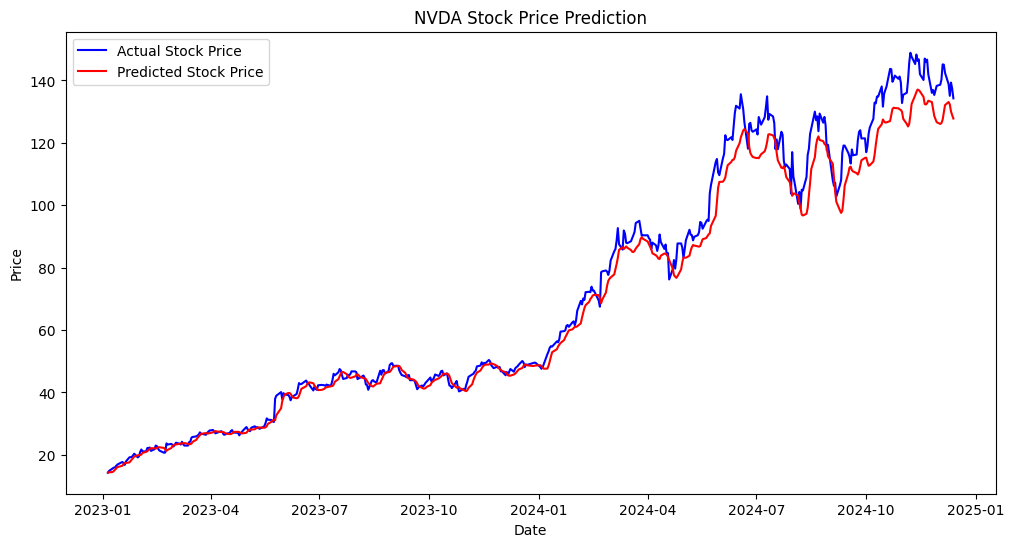

In [ ]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Fetch NVIDIA stock data from Yahoo Finance
stock_ticker = 'NVDA'  # NVIDIA stock ticker
data = yf.download(stock_ticker, start='2015-01-01', end='2024-12-15')
data = data[['Close']]  # Use only the 'Close' price

# Step 2: Data Preprocessing
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # Use 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 3: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for the next price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 4: Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# Step 5: Evaluate and Predict
# Predict on the testing set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling

# Reverse scaling for actual values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data.index[-len(y_test):], y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(data.index[-len(y_test):], predictions, color='red', label='Predicted Stock Price')
plt.title(f'{stock_ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Fetched News Headlines:
1. China opens an antitrust investigation into Nvidia
2. Nvidia Says Its Blackwell Chip Is Fine, Nothing to See Here
3. Forget The PS5 And Xbox, This Powerful Acer Nitro V Gaming Laptop Is at a Record Low Price

Average Sentiment Score: 0.18888888888888888


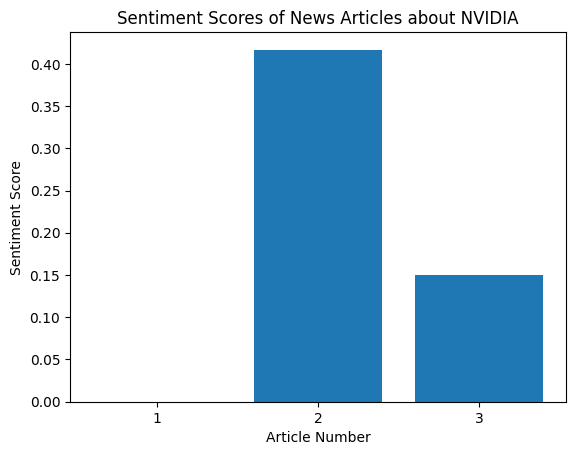

[*********************100%***********************]  1 of 1 completed


Mean Squared Error: 1884.0314522836493


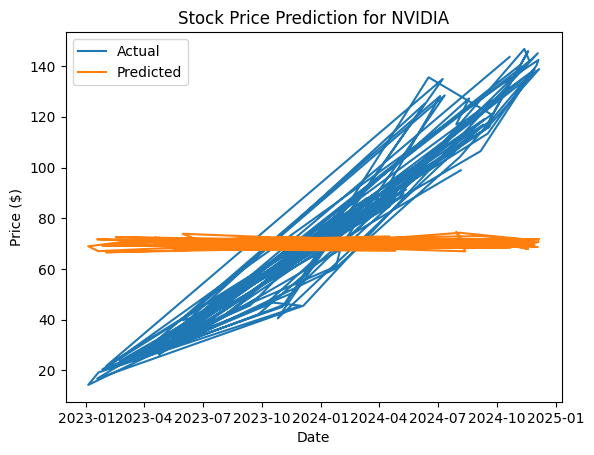

In [ ]:
import requests
from textblob import TextBlob
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

# Your NewsAPI key (keep it confidential)
api_key = 'f186b181214743ff95c70048b2f6f87b'

# Function to fetch news articles for NVIDIA and filter out any containing "[removed]"
def fetch_news(query, api_key, language='en', page_size=5):
    url = f'https://newsapi.org/v2/everything?q={query}&language={language}&pageSize={page_size}&apiKey={api_key}'
    response = requests.get(url)
    news_data = response.json()

    if news_data['status'] == 'ok':
        articles = news_data['articles']
        # Filter out articles that contain "[removed]"
        filtered_articles = [article['title'] for article in articles if "[Removed]" not in article['title']]
        return filtered_articles
    else:
        return []

# Fetch news about NVIDIA
nvidia_news = fetch_news('NVIDIA', api_key)

# Print the fetched news headlines
print("Fetched News Headlines:")
for i, headline in enumerate(nvidia_news, 1):
    print(f"{i}. {headline}")

# Sentiment Analysis of the fetched news headlines
def analyze_sentiment(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

# Analyze sentiment for each fetched headline
sentiment_scores = [analyze_sentiment(headline) for headline in nvidia_news]
avg_sentiment = sum(sentiment_scores) / len(sentiment_scores) if sentiment_scores else 0

# Display the average sentiment score
print(f"\nAverage Sentiment Score: {avg_sentiment}")

# Optional: Visualize the sentiment of each headline
plt.bar(range(len(nvidia_news)), sentiment_scores)
plt.xticks(range(len(nvidia_news)), range(1, len(nvidia_news) + 1))
plt.title("Sentiment Scores of News Articles about NVIDIA")
plt.xlabel("Article Number")
plt.ylabel("Sentiment Score")
plt.show()

# Fetch historical stock data for Nvidia
ticker = "NVDA"
stock_data = yf.download(ticker, start="2023-01-01", end="2024-12-15")

# Add sentiment as a feature in stock data (For simplicity, we're adding average sentiment to all rows)
stock_data['Sentiment'] = avg_sentiment  # Simplified by using one average sentiment score for all rows
stock_data['Returns'] = stock_data['Close'].pct_change()  # Calculate daily returns

# Drop missing values (due to the percentage change in returns)
stock_data = stock_data.dropna()

# Features and target
X = stock_data[['Sentiment', 'Returns']]
y = stock_data['Close'].shift(-1).dropna()  # Predict next day's closing price
X = X[:-1]  # Align features with target (remove the last row due to shift)

# Train-test split
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Plot predictions vs actual values
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title("Stock Price Prediction for NVIDIA")
plt.xlabel("Date")
plt.ylabel("Price ($)")
plt.show()


In [ ]:
pip install fredapi yfinance pandas numpy matplotlib tensorflow scikit-learn


[*********************100%***********************]  1 of 1 completed
<ipython-input-40-8b0b57b674e7>:63: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_monthly = data_monthly.fillna(method='ffill')  # Forward fill the missing data
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Price          Ticker
Close          NVDA      0
Inflation                0
GDP Growth               0
Interest Rate            0
dtype: int64
Epoch 1/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 33s 58ms/step - loss: 9.3291e-04 - val_loss: 0.0038
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - loss: 8.2876e-05 - val_loss: 0.0045
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 6.9331e-05 - val_loss: 0.0025
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 5.4339e-05 - val_loss: 0.0029
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 76ms/step - loss: 6.1468e-05 - val_loss: 0.0046
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 8.8992e-05 - val_loss: 0.0035
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 82ms/step - loss: 4.8619e-05 - val_loss: 0.0054
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - loss: 5.5152e-05 - val_loss: 0.0033
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step - loss: 5.4214e-05 - val_loss: 0.0037
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 52ms/step - l

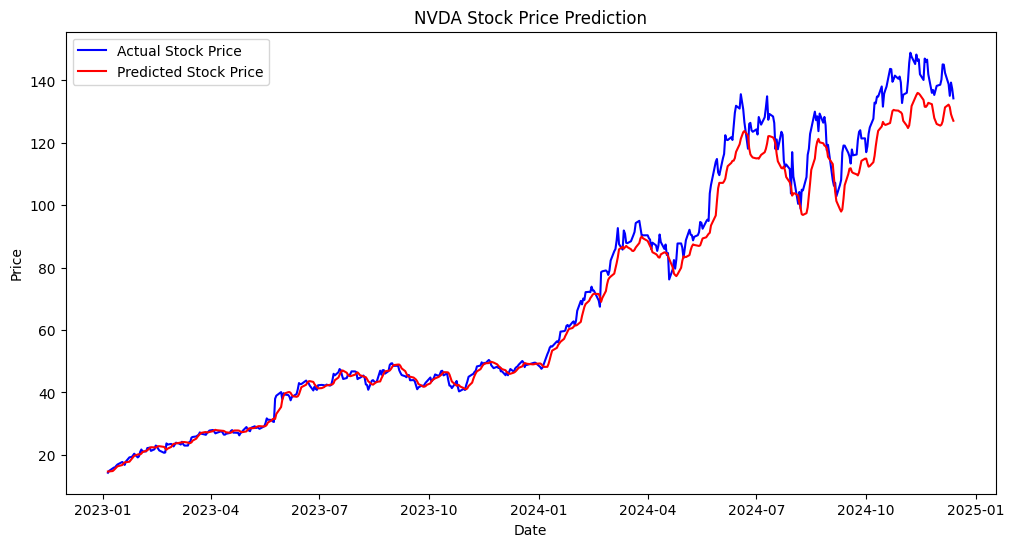

Final data shape: (2505, 4)
Price         Close Inflation GDP Growth Interest Rate
Ticker         NVDA                                   
Date                                                  
2015-01-02  0.50325 -0.998319  -0.612784      1.564696
2015-01-05  0.49475 -1.126967   0.253775      1.812309
2015-01-06  0.47975 -0.405532   0.681764     -0.809197
2015-01-07  0.47850  0.174310   0.255303     -0.124792
2015-01-08  0.49650 -0.876393  -0.624056     -1.342104


In [ ]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Step 1: Fetch NVIDIA stock data from Yahoo Finance
stock_ticker = 'NVDA'  # NVIDIA stock ticker
data = yf.download(stock_ticker, start='2015-01-01', end='2024-12-15')
data_monthly = data[['Close']]  # Use only the 'Close' price

# Step 2: Data Preprocessing
# Normalize the stock data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_monthly)

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # Use 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 3: Fetch External Data (Inflation, GDP Growth, Interest Rate)
# Example Data (Replace with actual data source)
inflation = pd.Series(np.random.randn(len(data_monthly)), index=data_monthly.index)
gdp_growth = pd.Series(np.random.randn(len(data_monthly)), index=data_monthly.index)
interest_rate = pd.Series(np.random.randn(len(data_monthly)), index=data_monthly.index)

# Step 4: Align lengths by removing extra data points from the longer datasets
min_length = min(len(inflation), len(gdp_growth), len(interest_rate))  # The minimum length (should match stock data length)

# Trim data to match the minimum length
data_monthly = data_monthly.iloc[:min_length]  # Trim stock data
inflation = inflation.iloc[:min_length]  # Trim inflation data
interest_rate = interest_rate.iloc[:min_length]  # Trim interest rate data

# Step 5: Merge the Datasets
data_monthly['Inflation'] = inflation.values
data_monthly['GDP Growth'] = gdp_growth.values
data_monthly['Interest Rate'] = interest_rate.values

# Check for missing values after merging
print(data_monthly.isna().sum())

# Step 6: Fill Missing Data (Forward Fill or Interpolation)
data_monthly = data_monthly.fillna(method='ffill')  # Forward fill the missing data

# Step 7: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for the next price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 8: Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# Step 9: Evaluate and Predict
# Predict on the testing set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling

# Reverse scaling for actual values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index[-len(y_test):], y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(data_monthly.index[-len(y_test):], predictions, color='red', label='Predicted Stock Price')
plt.title(f'{stock_ticker} Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Final check of the shape and the columns
print(f"Final data shape: {data_monthly.shape}")
print(data_monthly.head())


[*********************100%***********************]  1 of 1 completed


Price          Ticker
Close          NVDA      0
Inflation                0
GDP Growth               0
Interest Rate            0
dtype: int64
Epoch 1/50


<ipython-input-41-388739d6ad52>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['Inflation'] = inflation.values
<ipython-input-41-388739d6ad52>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['GDP Growth'] = gdp_growth.values
<ipython-input-41-388739d6ad52>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-

62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 56ms/step - loss: 0.0016 - val_loss: 0.0040
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 9.2537e-05 - val_loss: 0.0062
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 76ms/step - loss: 7.3922e-05 - val_loss: 0.0037
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 7.5156e-05 - val_loss: 0.0065
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - loss: 6.5138e-05 - val_loss: 0.0035
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 64ms/step - loss: 5.1567e-05 - val_loss: 0.0108
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 51ms/step - loss: 6.0143e-05 - val_loss: 0.0035
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 6s 63ms/step - loss: 6.0706e-05 - val_loss: 0.0056
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 5.2490e-05 - val_loss: 0.0049
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 5.4342e-05 - val_loss: 0.0053
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 5.4270e-05 - val_loss: 0.0044
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━

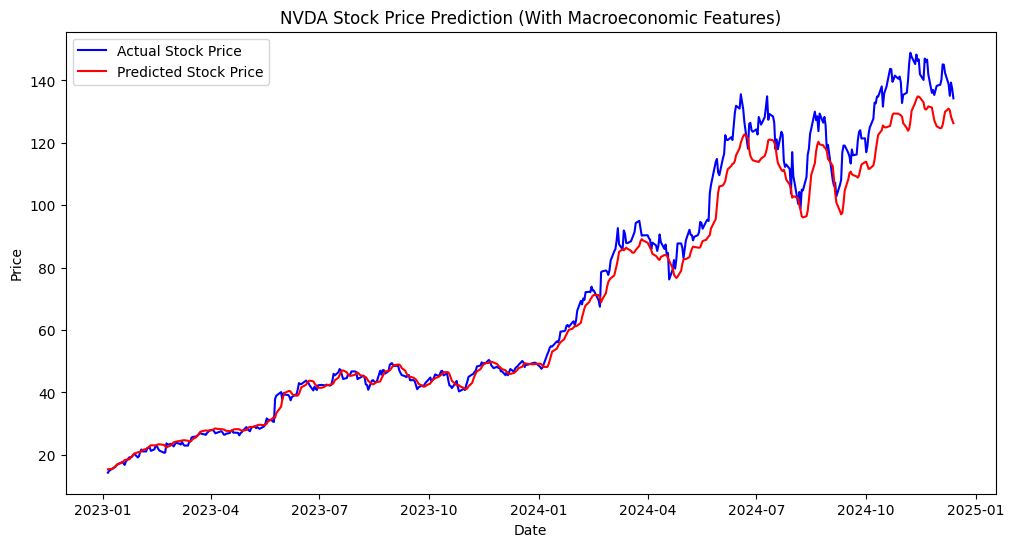

Final data shape: (2505, 4)
Price         Close Inflation GDP Growth Interest Rate
Ticker         NVDA                                   
Date                                                  
2015-01-02  0.50325     21.48       -1.0           0.8
2015-01-05  0.49475     21.48       -1.0           0.8
2015-01-06  0.47975     21.48       -1.0           0.8
2015-01-07  0.47850     21.48       -1.0           0.8
2015-01-08  0.49650     21.48       -1.0           0.8


In [ ]:
# Import libraries
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from fredapi import Fred  # FRED API for macroeconomic data

# Step 1: Fetch NVIDIA stock data from Yahoo Finance
stock_ticker = 'NVDA'  # NVIDIA stock ticker
data = yf.download(stock_ticker, start='2015-01-01', end='2024-12-15')
data_monthly = data[['Close']]  # Use only the 'Close' price

# Step 2: Fetch macroeconomic data from FRED (Inflation, GDP Growth, Interest Rates)
# You will need your FRED API key from https://fred.stlouisfed.org/
api_key = 'f00fd15c5439961e61801c7d97d715ef'
fred = Fred(api_key=api_key)

# Fetch macroeconomic data from FRED (Inflation, GDP Growth, Interest Rates)
inflation = fred.get_series('CPIAUCSL', start_date='2015-01-01', end_date='2024-12-15')
gdp_growth = fred.get_series('A191RL1Q225SBEA', start_date='2015-01-01', end_date='2024-12-15')
interest_rate = fred.get_series('FEDFUNDS', start_date='2015-01-01', end_date='2024-12-15')

# Resample the macroeconomic data to daily frequency and forward fill missing data
inflation = inflation.resample('D').ffill()  # Forward fill to daily
gdp_growth = gdp_growth.resample('D').ffill()  # Forward fill to daily
interest_rate = interest_rate.resample('D').ffill()  # Forward fill to daily

# Step 3: Align lengths by removing extra data points from the longer datasets
min_length = min(len(inflation), len(gdp_growth), len(interest_rate), len(data_monthly))  # Minimum length (should match stock data length)

# Trim data to match the minimum length
data_monthly = data_monthly.iloc[:min_length]  # Trim stock data
inflation = inflation.iloc[:min_length]  # Trim inflation data
gdp_growth = gdp_growth.iloc[:min_length]  # Trim GDP growth data
interest_rate = interest_rate.iloc[:min_length]  # Trim interest rate data

# Step 4: Merge the Datasets
data_monthly['Inflation'] = inflation.values
data_monthly['GDP Growth'] = gdp_growth.values
data_monthly['Interest Rate'] = interest_rate.values

# Check for missing values after merging
print(data_monthly.isna().sum())

# Step 5: Fill Missing Data (Forward Fill or Interpolation)
data_monthly = data_monthly.fillna(method='ffill')  # Forward fill missing data

# Step 6: Data Preprocessing
# Normalize the stock data (Close price)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_monthly[['Close']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

sequence_length = 60  # Use 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Step 7: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for the next price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 8: Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# Step 9: Evaluate and Predict
# Predict on the testing set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)  # Reverse scaling

# Reverse scaling for actual values
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# Step 10: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index[-len(y_test):], y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(data_monthly.index[-len(y_test):], predictions, color='red', label='Predicted Stock Price')
plt.title(f'{stock_ticker} Stock Price Prediction (With Macroeconomic Features)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Final check of the shape and the columns
print(f"Final data shape: {data_monthly.shape}")
print(data_monthly.head())  # Check the final merged data


[*********************100%***********************]  1 of 1 completed
<ipython-input-44-b56635d045de>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['Inflation'] = inflation.values
<ipython-input-44-b56635d045de>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['GDP Growth'] = gdp_growth.values
<ipython-input-44-b56635d045de>:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se

Epoch 1/50


<ipython-input-44-b56635d045de>:80: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  data_monthly = data_monthly.fillna(method='ffill')  # Forward fill missing data
/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 0.0043 - val_loss: 0.1281
Epoch 2/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - loss: 6.6480e-04 - val_loss: 0.0354
Epoch 3/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 3.8738e-04 - val_loss: 0.0297
Epoch 4/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 3.5850e-04 - val_loss: 0.0149
Epoch 5/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 2.1926e-04 - val_loss: 0.0101
Epoch 6/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 87ms/step - loss: 1.8689e-04 - val_loss: 0.0114
Epoch 7/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 8s 51ms/step - loss: 1.4361e-04 - val_loss: 0.0104
Epoch 8/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 1.5299e-04 - val_loss: 0.0142
Epoch 9/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 5s 77ms/step - loss: 1.7884e-04 - val_loss: 0.0157
Epoch 10/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - loss: 2.7666e-04 - val_loss: 0.0082
Epoch 11/50
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - loss: 1.2528e-04 - val_loss: 0.0103
Epoch 12/50
62/62 ━━━━━━━━━━━━━━━━

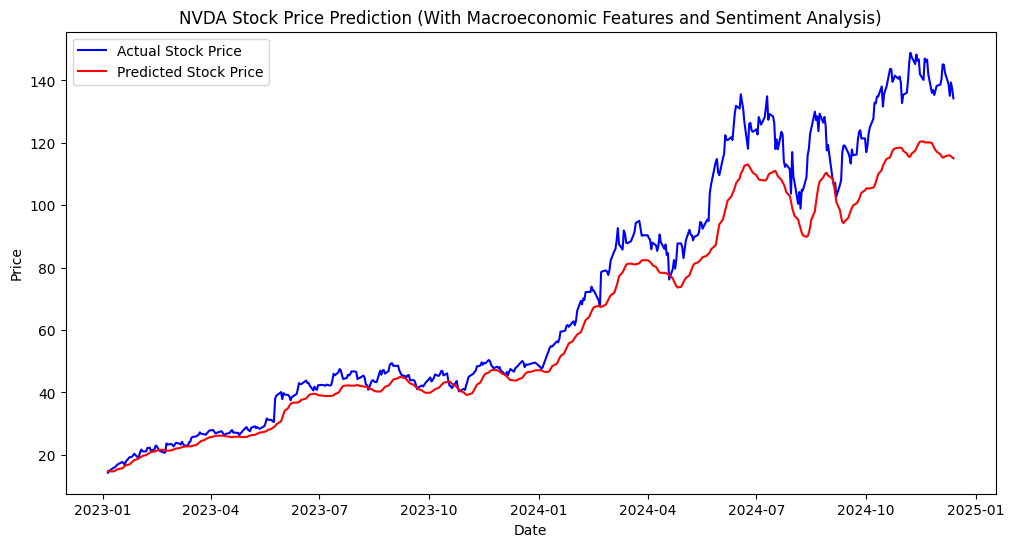

Final data shape: (2505, 5)
Price         Close Inflation GDP Growth Interest Rate Sentiment
Ticker         NVDA                                             
Date                                                            
2015-01-02  0.50325     21.48       -1.0           0.8         0
2015-01-05  0.49475     21.48       -1.0           0.8         0
2015-01-06  0.47975     21.48       -1.0           0.8         0
2015-01-07  0.47850     21.48       -1.0           0.8         0
2015-01-08  0.49650     21.48       -1.0           0.8         0


In [ ]:
# Import libraries
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from fredapi import Fred  # FRED API for macroeconomic data
from textblob import TextBlob

# Step 1: Fetch NVIDIA stock data from Yahoo Finance
stock_ticker = 'NVDA'  # NVIDIA stock ticker
data = yf.download(stock_ticker, start='2015-01-01', end='2024-12-15')
data_monthly = data[['Close']]  # Use only the 'Close' price

# Step 2: Fetch macroeconomic data from FRED (Inflation, GDP Growth, Interest Rates)
# You will need your FRED API key from https://fred.stlouisfed.org/
api_key = 'f00fd15c5439961e61801c7d97d715ef'
fred = Fred(api_key=api_key)

# Fetch macroeconomic data from FRED (Inflation, GDP Growth, Interest Rates)
inflation = fred.get_series('CPIAUCSL', start_date='2015-01-01', end_date='2024-12-15')
gdp_growth = fred.get_series('A191RL1Q225SBEA', start_date='2015-01-01', end_date='2024-12-15')
interest_rate = fred.get_series('FEDFUNDS', start_date='2015-01-01', end_date='2024-12-15')

# Resample the macroeconomic data to daily frequency and forward fill missing data
inflation = inflation.resample('D').ffill()  # Forward fill to daily
gdp_growth = gdp_growth.resample('D').ffill()  # Forward fill to daily
interest_rate = interest_rate.resample('D').ffill()  # Forward fill to daily

# Step 3: Align lengths by removing extra data points from the longer datasets
min_length = min(len(inflation), len(gdp_growth), len(interest_rate), len(data_monthly))  # Minimum length (should match stock data length)

# Trim data to match the minimum length
data_monthly = data_monthly.iloc[:min_length]  # Trim stock data
inflation = inflation.iloc[:min_length]  # Trim inflation data
gdp_growth = gdp_growth.iloc[:min_length]  # Trim GDP growth data
interest_rate = interest_rate.iloc[:min_length]  # Trim interest rate data

# Step 4: Merge the Datasets
data_monthly['Inflation'] = inflation.values
data_monthly['GDP Growth'] = gdp_growth.values
data_monthly['Interest Rate'] = interest_rate.values

# Step 5: Sentiment Analysis (fetch news and calculate sentiment)
def fetch_news(query, api_key, language='en', page_size=5):
    url = f'https://newsapi.org/v2/everything?q={query}&language={language}&pageSize={page_size}&apiKey={api_key}'
    response = requests.get(url)
    news_data = response.json()

    if news_data['status'] == 'ok':
        articles = news_data['articles']
        filtered_articles = [article['title'] for article in articles if "[removed]" not in article['title']]
        return filtered_articles
    else:
        return []

# Function to get sentiment of news titles
def get_sentiment_of_news(news_titles):
    def analyze_sentiment(text):
        blob = TextBlob(text)
        return blob.sentiment.polarity  # Returns a value between -1 (negative) and 1 (positive)

    sentiment_scores = [analyze_sentiment(headline) for headline in news_titles]
    return np.mean(sentiment_scores) if sentiment_scores else 0

# Fetch sentiment scores for each date in stock data (or on a regular basis)
sentiments = []
for date in data_monthly.index:
    news_titles = fetch_news("NVIDIA", api_key)
    sentiment_score = get_sentiment_of_news(news_titles)
    sentiments.append(sentiment_score)

# Add sentiment to the data
data_monthly['Sentiment'] = sentiments

# Step 6: Fill Missing Data (Forward Fill or Interpolation)
data_monthly = data_monthly.fillna(method='ffill')  # Forward fill missing data

# Step 7: Data Preprocessing
# Normalize the stock data (Close price) and other features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_monthly[['Close', 'Inflation', 'GDP Growth', 'Interest Rate', 'Sentiment']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Predict the 'Close' price
    return np.array(X), np.array(y)

sequence_length = 60  # Use 60 days of data to predict the next day's price
X, y = create_sequences(scaled_data, sequence_length)

# Split into training and testing data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, time_steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Step 8: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)  # Output layer for the next price
])

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Step 9: Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# Step 10: Evaluate and Predict
# Predict on the testing set
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]  # Reverse scaling

# Reverse scaling for actual values
y_test_scaled = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1]-1))), axis=1))[:, 0]

# Step 11: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index[-len(y_test):], y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(data_monthly.index[-len(y_test):], predictions, color='red', label='Predicted Stock Price')
plt.title(f'{stock_ticker} Stock Price Prediction (With Macroeconomic Features and Sentiment Analysis)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Final check of the shape and the columns
print(f"Final data shape: {data_monthly.shape}")
print(data_monthly.head())  # Check the final merged data



In [ ]:
# Import libraries
import requests
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from fredapi import Fred  # FRED API for macroeconomic data
from textblob import TextBlob

# Step 1: Fetch NVIDIA stock data from Yahoo Finance
stock_ticker = 'NVDA'  # NVIDIA stock ticker
data = yf.download(stock_ticker, start='2015-01-01', end='2024-12-15')
data_monthly = data[['Close']]  # Use only the 'Close' price

# Step 2: Fetch macroeconomic data from FRED (Inflation, GDP Growth, Interest Rates)
api_key = 'f00fd15c5439961e61801c7d97d715ef'
fred = Fred(api_key=api_key)

# Fetch macroeconomic data from FRED
inflation = fred.get_series('CPIAUCSL', start_date='2015-01-01', end_date='2024-12-15')
gdp_growth = fred.get_series('A191RL1Q225SBEA', start_date='2015-01-01', end_date='2024-12-15')
interest_rate = fred.get_series('FEDFUNDS', start_date='2015-01-01', end_date='2024-12-15')

# Resample the macroeconomic data to daily frequency and forward fill missing data
inflation = inflation.resample('D').ffill()
gdp_growth = gdp_growth.resample('D').ffill()
interest_rate = interest_rate.resample('D').ffill()

# Step 3: Align lengths by removing extra data points
min_length = min(len(inflation), len(gdp_growth), len(interest_rate), len(data_monthly))

data_monthly = data_monthly.iloc[:min_length]
inflation = inflation.iloc[:min_length]
gdp_growth = gdp_growth.iloc[:min_length]
interest_rate = interest_rate.iloc[:min_length]

# Step 4: Merge the Datasets
data_monthly['Inflation'] = inflation.values
data_monthly['GDP Growth'] = gdp_growth.values
data_monthly['Interest Rate'] = interest_rate.values

# Step 5: Sentiment Analysis (fetch news and calculate sentiment)
def fetch_news(query, api_key, language='en', page_size=5):
    url = f'https://newsapi.org/v2/everything?q={query}&language={language}&pageSize={page_size}&apiKey={api_key}'
    response = requests.get(url)
    news_data = response.json()

    if news_data['status'] == 'ok':
        articles = news_data['articles']
        filtered_articles = [article['title'] for article in articles if "[removed]" not in article['title']]
        return filtered_articles
    else:
        return []

def get_sentiment_of_news(news_titles):
    def analyze_sentiment(text):
        blob = TextBlob(text)
        return blob.sentiment.polarity

    sentiment_scores = [analyze_sentiment(headline) for headline in news_titles]
    return np.mean(sentiment_scores) if sentiment_scores else 0

sentiments = []
for date in data_monthly.index:
    news_titles = fetch_news("NVIDIA", api_key)
    sentiment_score = get_sentiment_of_news(news_titles)
    sentiments.append(sentiment_score)

data_monthly['Sentiment'] = sentiments

# Step 6: Fill Missing Data
data_monthly = data_monthly.fillna(method='ffill')

# Step 7: Data Preprocessing
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data_monthly[['Close', 'Inflation', 'GDP Growth', 'Interest Rate', 'Sentiment']])

# Create sequences for LSTM
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i + sequence_length])
        y.append(data[i + sequence_length, 0])  # Predict 'Close'
    return np.array(X), np.array(y)

sequence_length = 60
X, y = create_sequences(scaled_data, sequence_length)

# Split data
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Reshape data for LSTM [samples, time_steps, features]
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

# Step 8: Build the LSTM Model
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

model.compile(optimizer='adam', loss='mean_squared_error')

# Step 9: Train the Model
history = model.fit(X_train, y_train, batch_size=32, epochs=50, validation_data=(X_test, y_test))

# Step 10: Evaluate and Predict
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(
    np.concatenate((predictions, np.zeros((predictions.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]

y_test_scaled = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((y_test.shape[0], scaled_data.shape[1] - 1))), axis=1)
)[:, 0]

# Step 11: Plot the results
plt.figure(figsize=(12, 6))
plt.plot(data_monthly.index[-len(y_test):], y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(data_monthly.index[-len(y_test):], predictions, color='red', label='Predicted Stock Price')
plt.title(f'{stock_ticker} Stock Price Prediction (Multivariate LSTM)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Final Data Check
print(f"Final data shape: {data_monthly.shape}")
print(data_monthly.head())


[*********************100%***********************]  1 of 1 completed
<ipython-input-45-3c7320c6fad4>:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['Inflation'] = inflation.values
<ipython-input-45-3c7320c6fad4>:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_monthly['GDP Growth'] = gdp_growth.values
<ipython-input-45-3c7320c6fad4>:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

Se